In [22]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from sqlalchemy import create_engine, inspect, text
import os

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
engine = create_engine(os.environ["REDSHIFT_READ_URI"], echo=False)

def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  df = pd.DataFrame(dados, columns= consulta.keys())
  return df

In [3]:
producao = ''' 
select 
ap.created_at,
ap.deal_id,
down_payment,
installment,
operation_value,
proposal_type,
installment_count,
ap.days_of_delay,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
medium
from quiteja_dados.analitico_producao_7 ap
join quiteja_dados.dimensoes d on ap.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 7 and d.tipo_cluster = 'Atraso'
where ap.created_at > '2023-10-01' '''

In [4]:
consolidacao = '''
select 
deal_id,
contact_id,
debt_value,
principal_value,
days_of_delay,
coalesce(dm.de,0) || ' a ' || coalesce(dm.ate,0) as faixa_atraso,
contact_type,
contact_status  
from consolidacao_carteira.deal_39 d 
join consolidacao_carteira.customer_39 c on d.customer_id = c.customer_id and c.is_approachable is true and c.is_blacklist is False 
join consolidacao_carteira.contact_39 c2 on d.customer_id = c2.customer_id AND c2.is_blacklist is False AND c2.is_quarentine is false AND c2.is_contact_notifiable is true and has_hot is true
join quiteja_dados.dimensoes dm on d.days_of_delay between coalesce(dm.de,0) and coalesce(dm.ate) and dm.creditor_id = 7 and dm.tipo_cluster =  'Atraso'
'''


consolidacao_deal = '''
select 
distinct deal_id,
contact_id,
debt_value,
principal_value,
days_of_delay,
coalesce(dm.de,0) || ' a ' || coalesce(dm.ate,0) as faixa_atraso,
contact_type,
contact_status  
from consolidacao_carteira.deal_39 d 
join consolidacao_carteira.customer_39 c on d.customer_id = c.customer_id and c.is_approachable is true and c.is_blacklist is False 
join consolidacao_carteira.contact_39 c2 on d.customer_id = c2.customer_id AND c2.is_blacklist is False AND c2.is_quarentine is false AND c2.is_contact_notifiable is true and has_hot is true
join quiteja_dados.dimensoes dm on d.days_of_delay between coalesce(dm.de,0) and coalesce(dm.ate) and dm.creditor_id = 7 and dm.tipo_cluster =  'Atraso'
'''

In [5]:
estimulos = '''
select 
sent_at,
contact_id,
contact_type,
contact_final_score,
days_of_delay,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,999999) faixa_atraso,
debt_value,
principal_value,
incash_value,
incash_potential,
incash_discount,
max_installments,
strategy_public,
approach_type
from quiteja_dados.analitico_estimulos_7 ae
join quiteja_dados.dimensoes d on ae.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 7 and d.tipo_cluster = 'Atraso'
where sent_at  > '2024-01-01' '''

In [6]:
consolidacao = sql_df(consolidacao)

In [7]:
estimulos = sql_df(estimulos)

In [8]:
producao = sql_df(producao)

# Produção 

In [9]:
round(producao.describe(),2)

,deal_id,down_payment,installment,operation_value,installment_count,days_of_delay
count,1.610600e+04,16106.00,11778.00,16106.00,16106.00,16106.00
mean,1.646339e+08,236.54,1758.14,3927.03,8.41,263.05
std,3.785091e+07,562.90,2814.88,6515.14,7.47,264.67
min,7.292365e+06,12.00,37.15,50.96,0.00,4.00
25%,1.356097e+08,56.51,591.98,1221.21,0.00,79.00
50%,1.718126e+08,111.78,1063.74,2290.35,6.00,156.00
75%,1.897163e+08,241.87,1938.44,4581.96,11.00,378.00
max,2.471519e+08,35237.26,87875.92,234915.06,23.00,1924.00


<Axes: xlabel='operation_value', ylabel='faixa_atraso'>

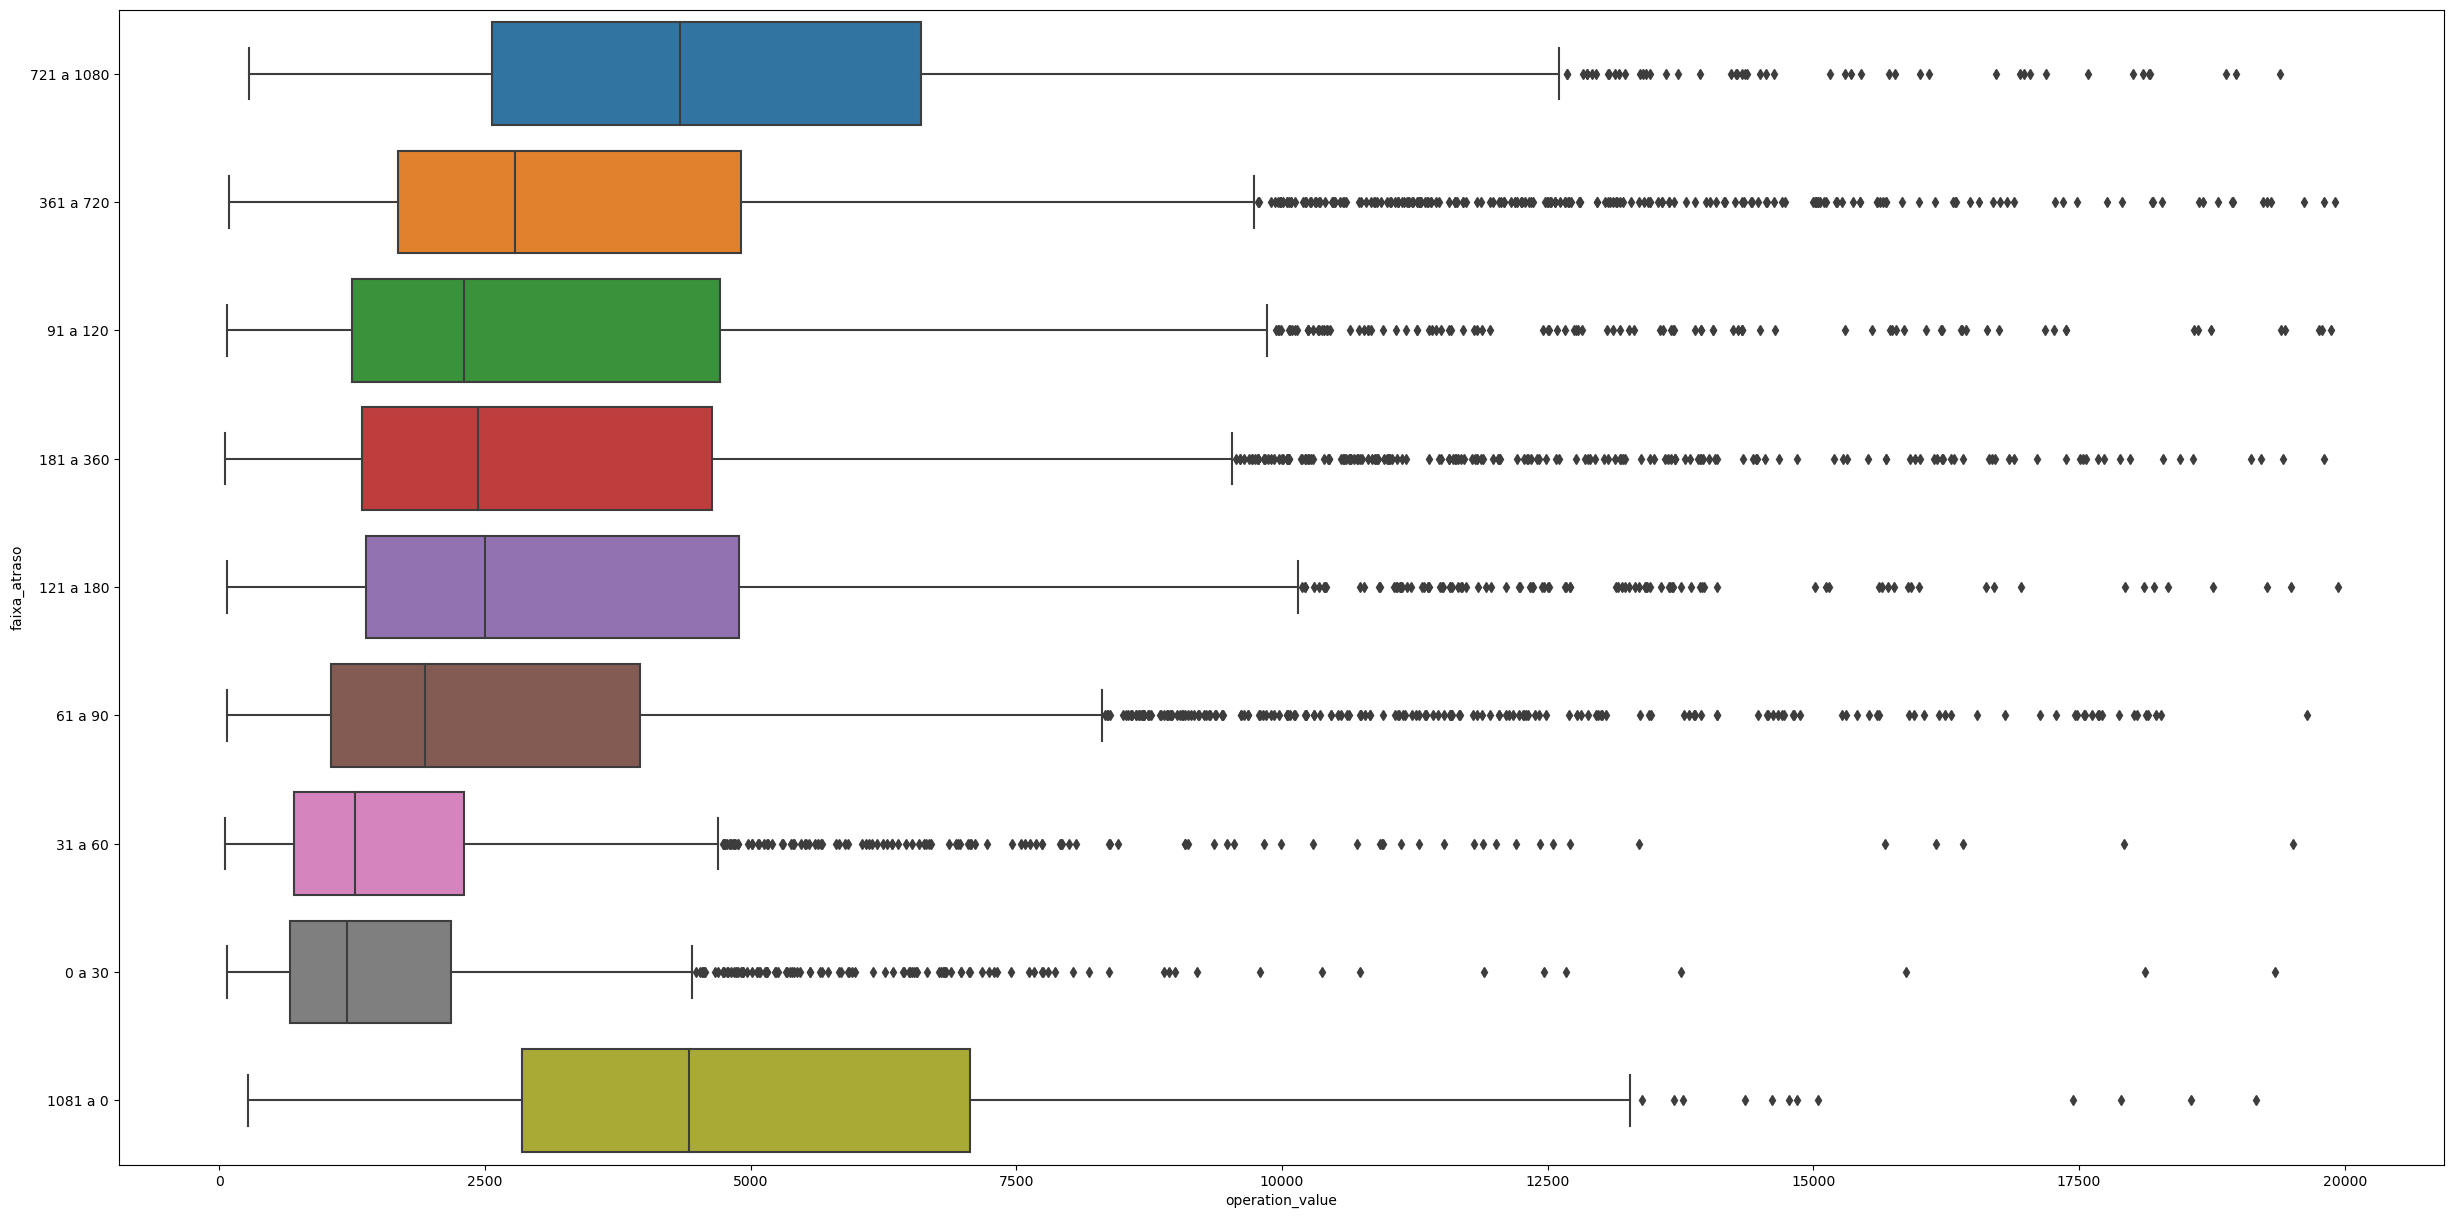

In [10]:
plt.figure(figsize=(30,15))
sns.boxplot(x = producao[producao['operation_value'] < 20000]['operation_value'], y=producao['faixa_atraso'])

<Axes: xlabel='operation_value', ylabel='Count'>

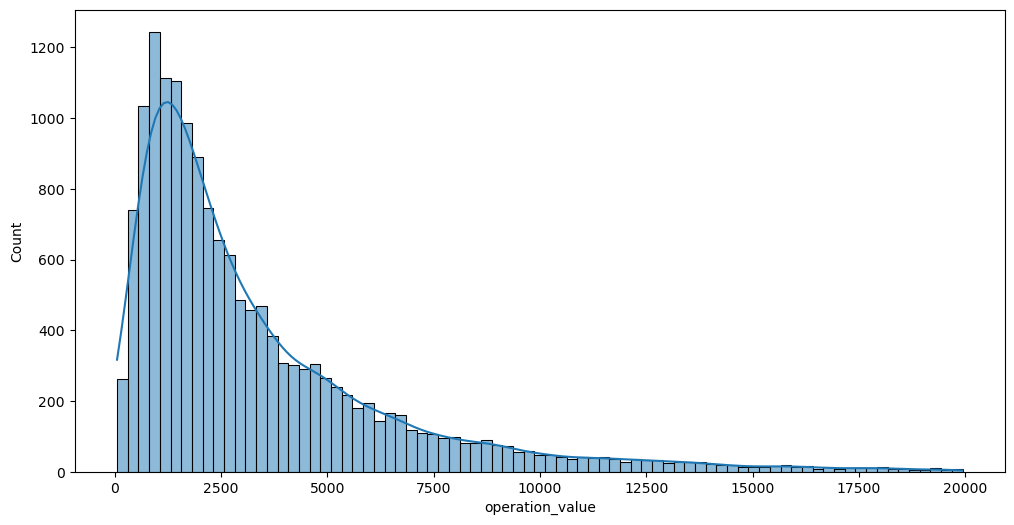

In [11]:
plt.figure(figsize=(12,6))
sns.histplot(producao[producao['operation_value'] < 20000]['operation_value'], kde = True)

In [12]:
round(pd.crosstab(producao['proposal_type'], producao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,1081 a 0,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
proposal_type,,,,,,,,,
A prazo,8.57,1.08,7.32,12.39,7.97,11.93,12.27,4.51,7.08
A vista,0.83,0.25,2.68,7.57,1.20,7.20,3.19,1.59,2.36


In [13]:
round(pd.crosstab(producao['medium'], producao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,1081 a 0,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
medium,,,,,,,,,
E-MAIL,0.65,0.15,1.28,2.47,0.86,2.49,1.46,0.66,1.21
ORGANICO,0.77,0.09,1.09,1.47,0.80,1.22,1.12,0.42,0.73
PUSH,0.30,0.03,0.37,0.71,0.22,0.59,0.34,0.20,0.32
SMS,4.93,0.51,4.54,8.48,4.74,7.18,8.96,2.29,4.56
URA,0.01,0.00,0.03,0.04,0.01,0.01,0.04,0.01,0.01
WHATSAPP,2.74,0.55,2.68,6.79,2.54,7.65,3.55,2.52,2.60


É possível observar que a faixa de atraso de 181-360 e 361-720 possuem um bom potêncial de produção tanto para cash quanto colchão. Todas essas faixas tem boa produção em E-mail, SMS e Whats!

# Estímulos

In [14]:
round(estimulos.describe(),2)

,contact_id,contact_final_score,days_of_delay,debt_value,principal_value,incash_value,incash_potential,incash_discount,max_installments
count,1.187634e+07,9763293.00,11876343.00,11876343.00,10475365.00,11861554.00,11861554.00,11532521.00,11858794.00
mean,2.094535e+08,4.68,477.04,5136.02,5024.59,1173.09,171.24,0.74,23.54
std,7.400391e+07,11.87,287.08,7482.42,7289.84,2082.42,274.54,0.21,2.20
min,2.165000e+03,0.00,1.00,-754.97,-754.97,0.78,0.11,0.00,6.00
25%,1.736109e+08,0.50,250.00,1677.19,1643.85,366.59,55.40,0.75,24.00
50%,2.131068e+08,1.00,461.00,3107.09,3047.97,651.32,99.23,0.85,24.00
75%,2.748510e+08,6.75,649.00,5779.02,5666.73,1230.22,186.13,0.85,24.00
max,3.229684e+08,1331.00,2668.00,510121.81,506862.66,250102.19,27180.41,0.85,24.00


In [15]:
estimulos['faixa_atraso'].value_counts(normalize=True).sort_values(ascending=False)

361 a 720        0.438743
181 a 360        0.196395
721 a 1080       0.165053
121 a 180        0.062905
61 a 90          0.040511
91 a 120         0.035293
1081 a 999999    0.022729
31 a 60          0.022456
0 a 30           0.015914
Name: faixa_atraso, dtype: float64

In [16]:
round(pd.crosstab(estimulos['strategy_public'], estimulos['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,1081 a 999999,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
strategy_public,,,,,,,,,
CHECKED,0.95,1.17,4.52,13.71,1.26,30.31,1.80,10.45,2.39
IMPORTED,0.05,0.03,0.23,0.47,0.01,0.93,1.39,0.29,0.32
LOCATED,0.59,1.07,1.54,5.45,0.97,12.59,0.82,5.76,0.81
UNCHECKED,0.01,0.00,0.00,0.01,0.01,0.04,0.03,0.01,0.01


In [17]:
round(pd.crosstab(estimulos['approach_type'], estimulos['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,1081 a 999999,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
approach_type,,,,,,,,,
EMAIL,0.73,1.29,4.47,14.06,0.79,31.34,1.96,11.03,1.89
PUSH,0.25,0.58,0.87,3.15,0.42,8.19,0.39,3.47,0.44
SMS,0.56,0.36,0.90,2.25,0.98,3.88,1.66,1.81,1.17
WHATSAPP,0.05,0.03,0.05,0.18,0.06,0.46,0.04,0.19,0.03


In [18]:
estimulos['approach_type'].value_counts(normalize=True)

EMAIL       0.675664
PUSH        0.177555
SMS         0.135833
WHATSAPP    0.010948
Name: approach_type, dtype: float64

Pela frequencia é possível notar que já foi trabalhado bastante em clientes da faixa 361-720. Que a faixa 181-360 é a segunda mais trabalhada, porém pode existir mais espaço para exploração!! 

Outro fator interessante dos estímulos é que ela é tem bastante estimulos feitos em E-mail, e a faixa escolhida produz bem em SMS e Whatsapp o que pode ser um direcionamento interessante pra estratégia.

# Consolidação 

In [19]:
consolidacao_unique = consolidacao.groupby(by='deal_id').mean().reset_index()

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_13800\735628214.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  consolidacao_unique = consolidacao.groupby(by='deal_id').mean().reset_index()


In [20]:
round(consolidacao_unique.describe(),2)

,deal_id,contact_id,debt_value,principal_value,days_of_delay
count,4.940000e+02,4.940000e+02,494.00,494.00,494.00
mean,2.752745e+08,2.494001e+08,4506.78,4506.78,369.88
std,4.896488e+05,6.275277e+07,7570.15,7570.15,254.69
min,2.676680e+08,6.320900e+05,105.07,105.07,13.00
25%,2.752870e+08,2.174807e+08,1298.12,1298.12,176.50
50%,2.752872e+08,2.651339e+08,2436.64,2436.64,323.50
75%,2.752878e+08,2.958704e+08,5315.39,5315.39,530.00
max,2.755573e+08,3.390509e+08,108533.67,108533.67,1079.00


In [21]:
con_deal = sql_df(consolidacao_deal)

In [22]:
pd.DataFrame({'Tamanho Base': (con_deal['faixa_atraso'].value_counts(normalize=True) * 100).apply('{:.2f}%'.format)})

,Tamanho Base
361 a 720,36.75%
181 a 360,26.58%
721 a 1080,11.63%
121 a 180,7.78%
61 a 90,7.78%
31 a 60,3.78%
0 a 30,3.00%
91 a 120,2.70%


In [23]:
round(pd.crosstab(consolidacao['contact_type'], consolidacao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
contact_type,,,,,,,,
CELLPHONE,1.62,3.85,13.25,2.47,18.34,4.16,6.01,1.39
DEVICE_TOKEN,0.69,0.85,4.16,0.54,6.32,1.31,1.54,0.39
EMAIL,0.69,3.08,9.17,0.77,12.10,2.31,4.08,0.92


In [24]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['faixa_atraso'], normalize=True) * 100,2)

faixa_atraso,0 a 30,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
contact_status,,,,,,,,
CONFIRMED,2.31,6.16,22.11,2.70,28.66,6.09,8.40,2.23
CREATED,0.69,1.62,4.47,1.08,8.09,1.69,3.24,0.46


In [25]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['contact_type'],  normalize=True) * 100,2)

contact_type,CELLPHONE,DEVICE_TOKEN,EMAIL
contact_status,,,
CONFIRMED,34.82,15.79,28.04
CREATED,16.26,0.00,5.08


É possível verficar que a faixa de 181-360 é a terceira com maior frequencia na consolidação, além de ser a terceira faixa com maior percentual de contatos hot. 

Sobre contatos hot, a maioria é celular (o que pode ser mais um indicativo interessante de trabalhar sobre o SMS)

# KPIs

## Canal

In [26]:
KPI_CANAL = '''
select 
created_at,
medium,
case when promessas is null then 0::float else promessas::float end promessas,
case when custo is null then 0::float else custo::float end custo
from (
select 
created_at,
medium,
count(distinct analitico_producao_7.deal_id) promessas
from quiteja_dados.analitico_producao_7
where 1=1
and date(analitico_producao_7.created_at) > date '2023-01-01' 
group by 1,2) producao
left join 
(select 
sent_at,
case when analitico_estimulos_7.approach_type = 'EMAIL' then 'E-MAIL'
	 when analitico_estimulos_7.approach_type = 'CALL_CELLPHONE' then 'URA'
	 else analitico_estimulos_7.approach_type end approach_type,
sum(1 * approach_cost) custo
from quiteja_dados.analitico_estimulos_7
join quiteja_lake.firing f on f.id = analitico_estimulos_7.firing_id 
where date(sent_at) > '2023-01-01' 
group by 1,2) custo on custo.sent_at = producao.created_at and producao.medium = custo.approach_type
order by 1,2
'''

In [27]:
KPI_Canal = sql_df(KPI_CANAL)
KPI_Canal['created_at'] = pd.to_datetime(KPI_Canal['created_at'])

In [ ]:
KPI_Canal['CPP'] = KPI_Canal['custo'] / KPI_Canal['promessas']

In [ ]:
KPI_Canal['Dia_mes'] = KPI_Canal['created_at'].dt.day

In [ ]:
KPI_Canal_grouped = KPI_Canal.groupby(by=['Dia_mes', 'medium']).agg({'CPP':'mean'}).reset_index()


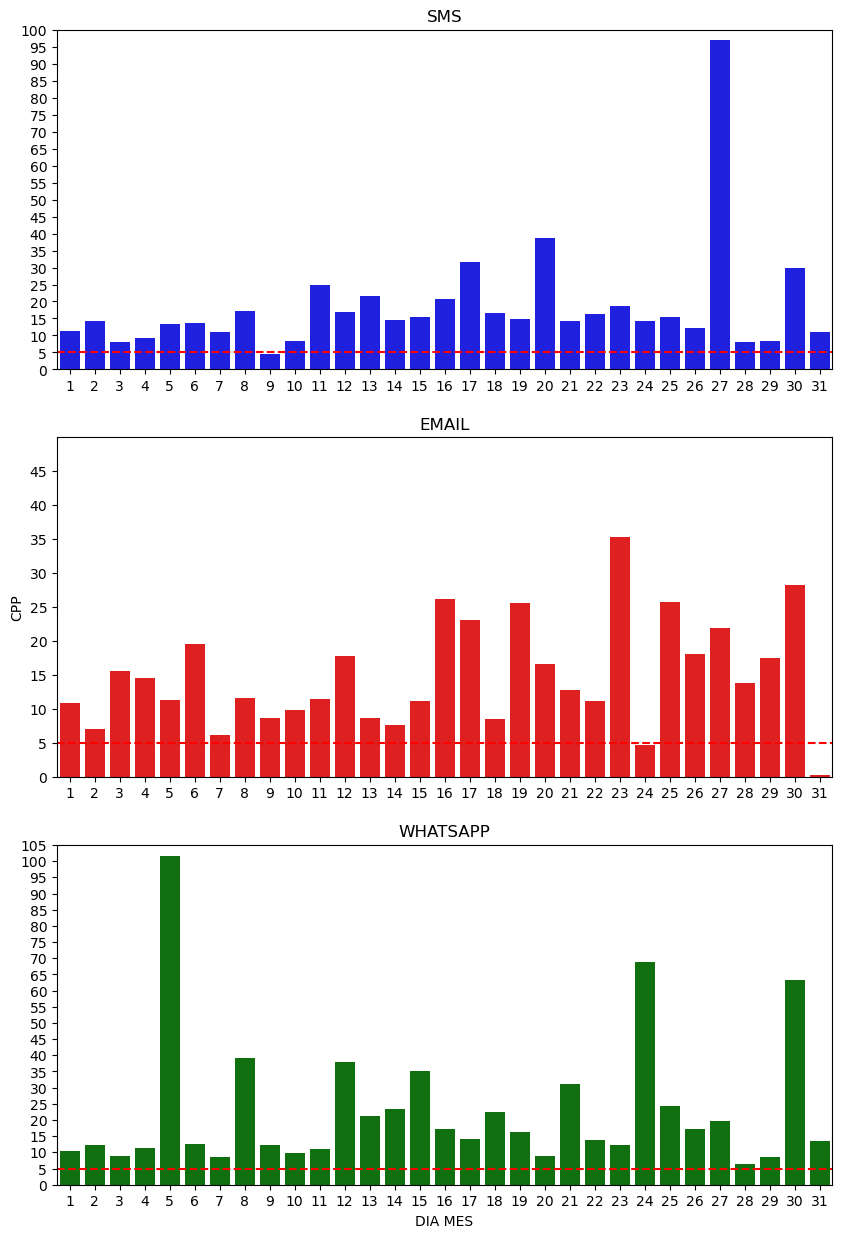

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium'] == 'SMS']['CPP'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 100)
axs[0].yaxis.set_ticks(range(0, 101, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='E-MAIL']['CPP'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 50)
axs[1].yaxis.set_ticks(range(0, 50, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='WHATSAPP']['CPP'], ax=axs[2],color='green')
axs[2].set_title('WHATSAPP')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 105)
axs[2].yaxis.set_ticks(range(0, 106, 5))
axs[2].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal Sob Ótica do CPP:

SMS - 3, 9, 10, 28, 29

E-MAIL - 2, 7, 14, 24, 31

WHATSAPP - 3, 7, 20, 28, 29

## Faixa de Atraso

In [ ]:
KPI_FA = '''
select 
created_at,
producao.cod_cluster,
producao.faixa_atraso,
case when promessas is null then 0::float else promessas::float end promessas,
case when custo is null then 0::float else custo::float end custo
from (
select 
created_at,
d.cod_cluster,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
count(distinct analitico_producao_7.deal_id) promessas
from quiteja_dados.analitico_producao_7
join quiteja_dados.dimensoes d on analitico_producao_7.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 7 and d.tipo_cluster = 'Atraso'
where 1=1
and date(analitico_producao_7.created_at) > date '2023-01-01' 
group by 1,2,3) producao
left join 
(select 
sent_at,
d.cod_cluster,
coalesce(d.de,0) || ' a ' || coalesce(d.ate,0) as faixa_atraso,
sum(1 * approach_cost) custo
from quiteja_dados.analitico_estimulos_7
join quiteja_lake.firing f on f.id = analitico_estimulos_7.firing_id 
join quiteja_dados.dimensoes d on analitico_estimulos_7.days_of_delay between coalesce(d.de,0) and coalesce(d.ate,999999) and d.creditor_id = 7 and d.tipo_cluster = 'Atraso'
where date(sent_at) > '2023-01-01' 
group by 1,2,3) custo on custo.sent_at = producao.created_at and producao.cod_cluster = custo.cod_cluster
order by 1,2
'''

In [ ]:
KPI_FA = sql_df(KPI_FA)
KPI_FA['created_at'] = pd.to_datetime(KPI_FA['created_at'])

In [ ]:
KPI_FA['CPP'] = KPI_FA['custo'] / KPI_FA['promessas']

In [ ]:
KPI_FA['Dia_mes'] = KPI_FA['created_at'].dt.day

In [ ]:
KPI_FA_grouped = KPI_FA.groupby(by=['Dia_mes', 'cod_cluster','faixa_atraso']).agg({'CPP':'mean'}).reset_index()

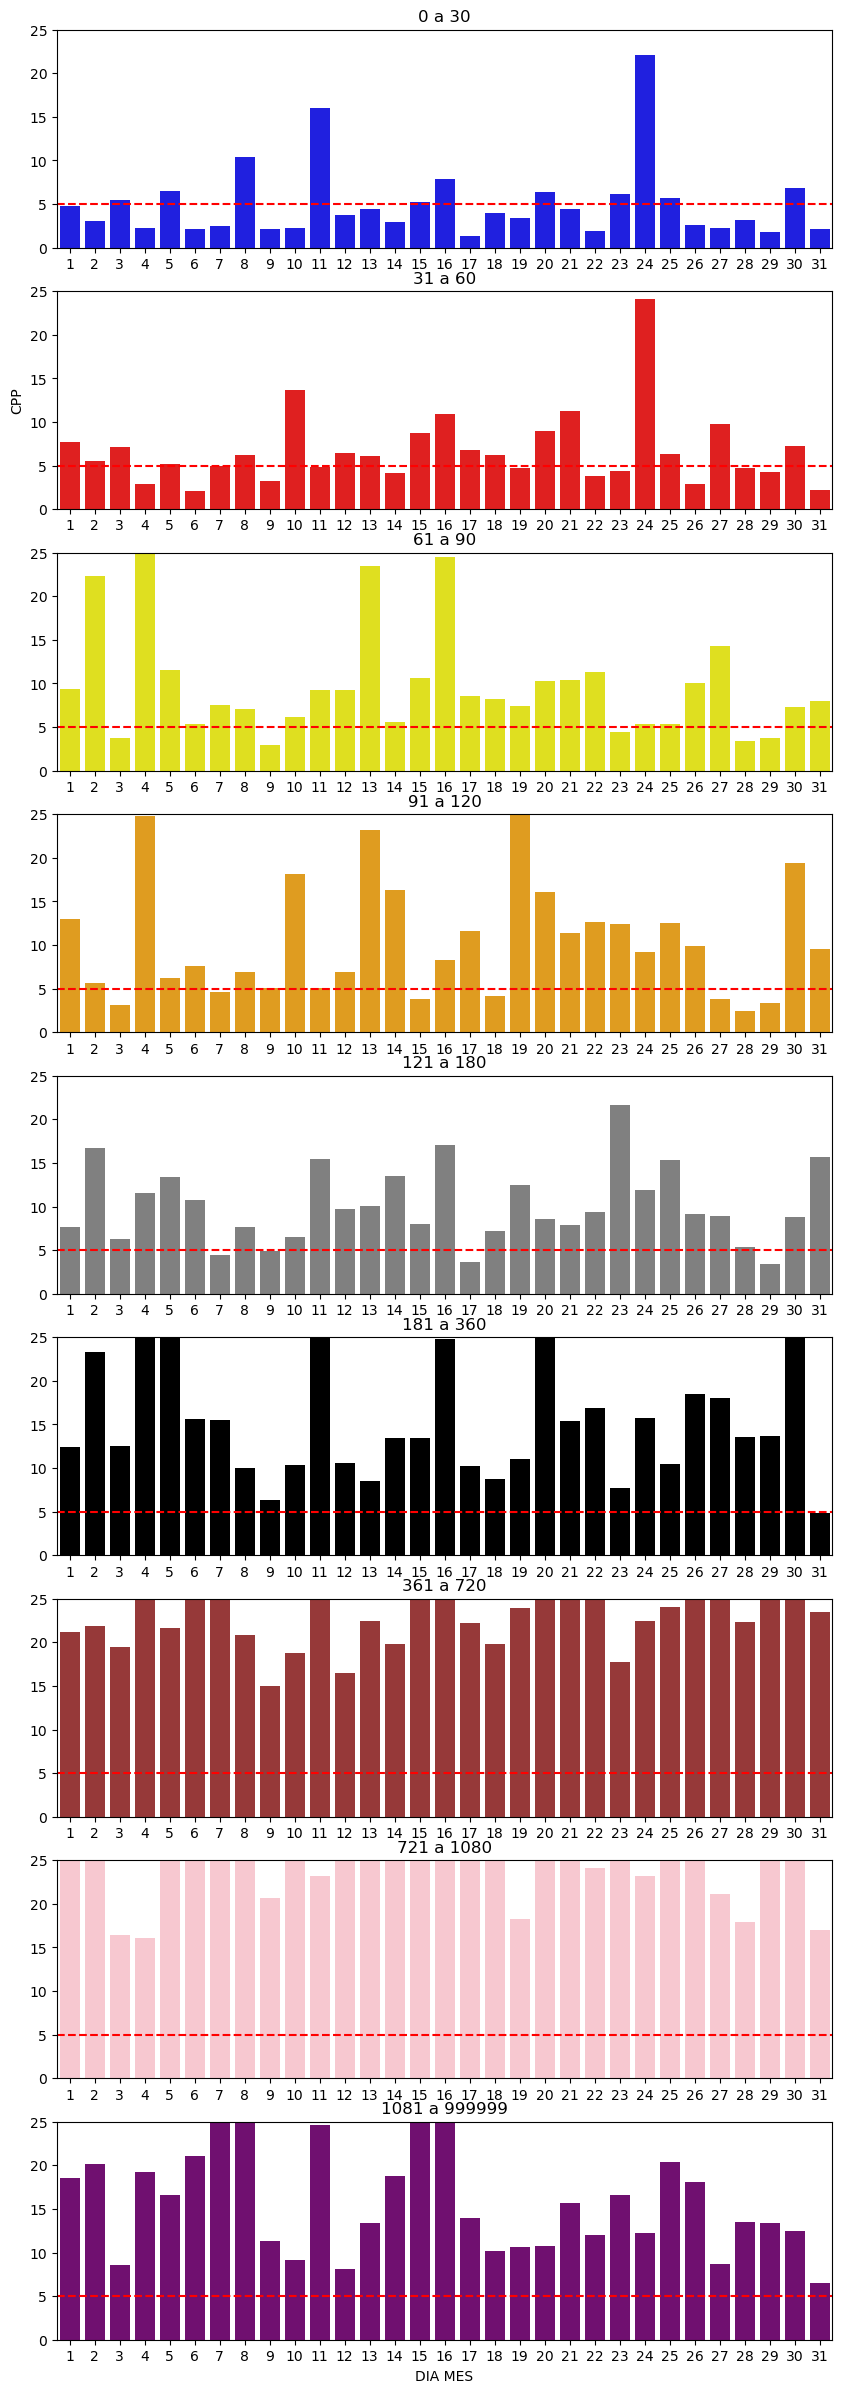

In [ ]:
fig, axs = plt.subplots(9, 1, figsize=(10, 30))
#0 a 30
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster'] == 1]['CPP'], ax=axs[0], color='blue')
axs[0].set_title('0 a 30')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 25)
axs[0].yaxis.set_ticks(range(0, 26, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#31 a 60
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==2]['CPP'], ax=axs[1],color='red')
axs[1].set_title('31 a 60')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 25)
axs[1].yaxis.set_ticks(range(0, 26, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#61 a 90
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==3]['CPP'], ax=axs[2],color='yellow')
axs[2].set_title('61 a 90')
axs[2].set_xlabel('') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 25)
axs[2].yaxis.set_ticks(range(0, 26, 5)) 
axs[2].axhline(y=5, color='r', linestyle='--')
#91 a 120
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==4]['CPP'], ax=axs[3],color='orange')
axs[3].set_title('91 a 120')
axs[3].set_xlabel('') 
axs[3].set_ylabel('')
axs[3].set_ylim(0, 25)
axs[3].yaxis.set_ticks(range(0, 26, 5)) 
axs[3].axhline(y=5, color='r', linestyle='--')
#121 a 180
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==5]['CPP'], ax=axs[4],color='gray')
axs[4].set_title('121 a 180')
axs[4].set_xlabel('') 
axs[4].set_ylabel('')
axs[4].set_ylim(0, 25)
axs[4].yaxis.set_ticks(range(0, 26, 5)) 
axs[4].axhline(y=5, color='r', linestyle='--')
#181 a 360	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==6]['CPP'], ax=axs[5],color='black')
axs[5].set_title('181 a 360')
axs[5].set_xlabel('') 
axs[5].set_ylabel('')
axs[5].set_ylim(0, 25)
axs[5].yaxis.set_ticks(range(0, 26, 5)) 
axs[5].axhline(y=5, color='r', linestyle='--');
#361 a 720
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==7]['CPP'], ax=axs[6],color='brown')
axs[6].set_title('361 a 720')
axs[6].set_xlabel('') 
axs[6].set_ylabel('')
axs[6].set_ylim(0, 25)
axs[6].yaxis.set_ticks(range(0, 26, 5)) 
axs[6].axhline(y=5, color='r', linestyle='--')
#721 a 1080
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==8]['CPP'], ax=axs[7],color='pink')
axs[7].set_title('721 a 1080')
axs[7].set_xlabel('') 
axs[7].set_ylabel('')
axs[7].set_ylim(0, 25)
axs[7].yaxis.set_ticks(range(0, 26, 5)) 
axs[7].axhline(y=5, color='r', linestyle='--')
#1081 a 0	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==9]['CPP'], ax=axs[8],color='purple')
axs[8].set_title('1081 a 999999')
axs[8].set_xlabel('DIA MES') 
axs[8].set_ylabel('')
axs[8].set_ylim(0, 25)
axs[8].yaxis.set_ticks(range(0, 26, 5)) 
axs[8].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Faixa de Atraso Sob Ótica do CPP:

181 - 360 - 9, 23, 31

121 - 180 - 7, 9, 17, 29


Melhores Períodos para Estímulo por Canal e Faixa de Atraso Sob Ótica do CPP:

SMS (181 - 360) 9, 10

E-MAIL (181 - 360) - 31

SMS (121 - 180) - 9, 10, 28, 29

E-MAIL (121 - 180) - 7

WHATSAPP (121 - 180) - 7, 29


In [ ]:
KPI_CPL = ''' 

select 
f.created_at, 
approach_type,
case when sum(notifications * approach_cost) = 0 or sum(localized) = 0 then 0 else sum(notifications * approach_cost) / sum(localized)::float end CPL
from quiteja_lake.firing f 
where creditor_id = 7 and strategy_public != 'LOCATED'
group by 1,2

'''

In [ ]:
KPI_CPL = sql_df(KPI_CPL)

In [ ]:
KPI_CPL['created_at'] = pd.to_datetime(KPI_CPL['created_at'])
KPI_CPL['Dia_mes'] = KPI_CPL['created_at'].dt.day

In [ ]:
KPI_CPL_grouped = KPI_CPL.groupby(by=['Dia_mes', 'approach_type']).agg({'cpl':'mean'}).reset_index()

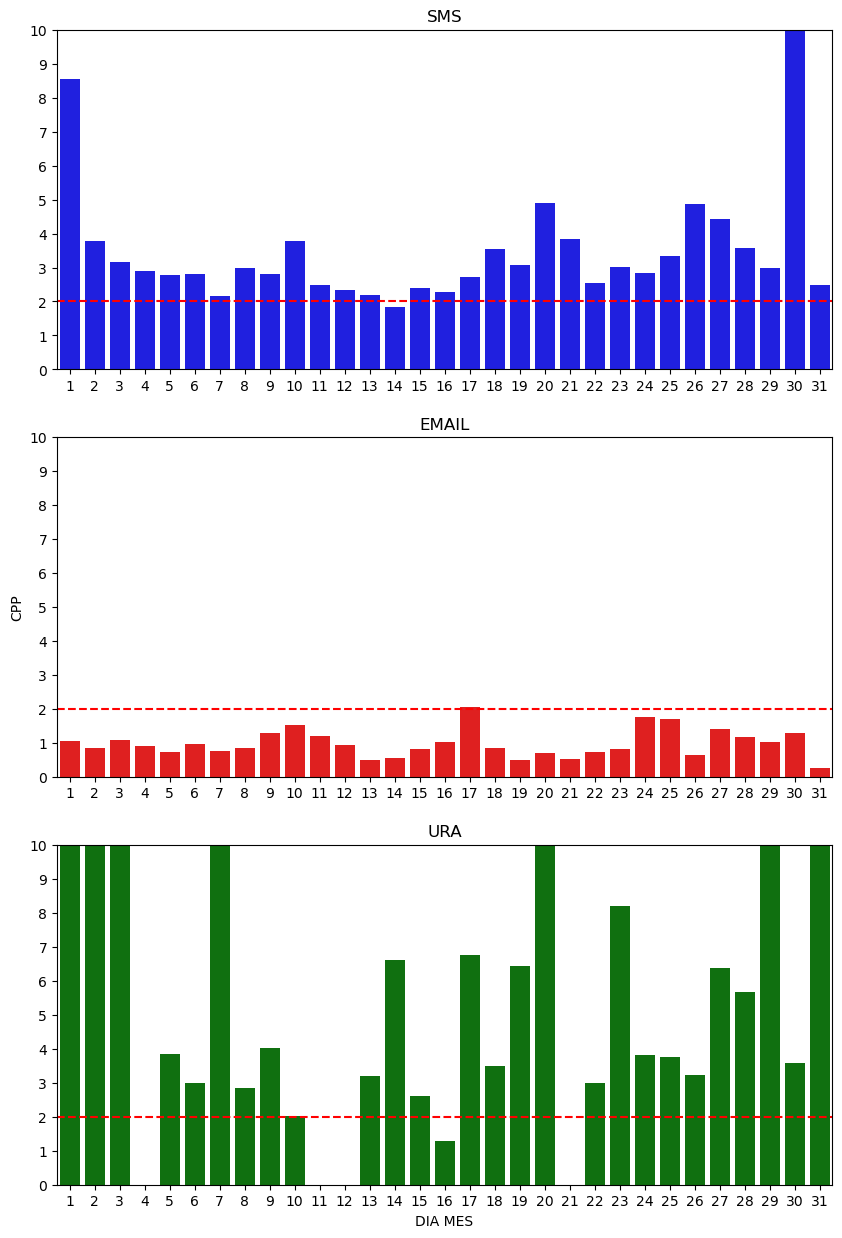

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type'] == 'SMS']['cpl'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 10)
axs[0].yaxis.set_ticks(range(0, 11, 1))
axs[0].axhline(y=2, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='EMAIL']['cpl'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 10)
axs[1].yaxis.set_ticks(range(0, 11, 1)) 
axs[1].axhline(y=2, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='CALL_CELLPHONE']['cpl'], ax=axs[2],color='green')
axs[2].set_title('URA')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 10)
axs[2].yaxis.set_ticks(range(0, 11, 1))
axs[2].axhline(y=2, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal Sob Ótica do CPL:

URA - 10, 16 

SMS - 7, 11 até 16

EMAIL - Durante todo mês

# CONCLUSÃO 

O estudo foi realizado levando em consideração dados de estímulos desse ano, e dados de produção de 2023 para frente. 

Análise foi realizada em cima das faixas de atraso e trouxe 3 visões:

Produção

Estimulos

Distribuição da carteira.

E a conclusão é que pode ter um espaço para melhoria de performace trabalhando melhor as faixas de atraso de 181-360 e 121-180, os indicativos são:


1) Olhando para produção desse ano foi possível ver que as faixas que mais produziram foi de 181-360, 361-720, e 121-180. Além de que na média possuem um valor de operação aproximado da maior frequencia de valor de operação da produção geral.

2) Ainda sobre produção, foi possível notar que essas faixas produzem muito bem em SMS, Email e Whats. Porém a maior frequência de produção é SMS.

In [ ]:
(pd.crosstab(producao['medium'], producao['faixa_atraso'], normalize=True) * 100).style.background_gradient(axis=1, cmap='YlOrRd')

faixa_atraso,0 a 30,1081 a 0,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
medium,,,,,,,,,
E-MAIL,0.651931,0.149013,1.279026,2.471129,0.863032,2.489755,1.459084,0.664349,1.210729
ORGANICO,0.769899,0.093133,1.092760,1.465292,0.800944,1.223147,1.117596,0.415994,0.732646
PUSH,0.298026,0.031044,0.372532,0.714020,0.217310,0.589842,0.341488,0.198684,0.322861
SMS,4.929840,0.509127,4.544890,8.481311,4.743574,7.177449,8.959394,2.291072,4.557308
URA,0.012418,0.000000,0.031044,0.037253,0.006209,0.006209,0.037253,0.006209,0.012418
WHATSAPP,2.744319,0.546380,2.682230,6.786291,2.539426,7.649323,3.551472,2.520800,2.601515


3) Foi possível verificar que as faixas de atraso 121-180 e 181-360 não foram tão estimuladas quanto a de 361-720, portanto tem espaço para crescimento ainda.


In [ ]:
pd.DataFrame((estimulos['faixa_atraso'].value_counts(normalize=True) * 100).sort_values(ascending=False)).style.background_gradient(axis=0, cmap='YlOrRd')

,faixa_atraso
361 a 720,43.874339
181 a 360,19.639522
721 a 1080,16.505342
121 a 180,6.290489
61 a 90,4.051079
91 a 120,3.529260
1081 a 999999,2.272930
31 a 60,2.245616
0 a 30,1.591424


In [ ]:
(pd.crosstab(estimulos['approach_type'], estimulos['faixa_atraso'], normalize=True) * 100).style.background_gradient(axis=1, cmap='YlOrRd')

faixa_atraso,0 a 30,1081 a 999999,121 a 180,181 a 360,31 a 60,361 a 720,61 a 90,721 a 1080,91 a 120
approach_type,,,,,,,,,
EMAIL,0.733888,1.294624,4.470678,14.056019,0.794765,31.338485,1.961850,11.027376,1.888721
PUSH,0.247517,0.580962,0.868087,3.149749,0.419009,8.188817,0.387173,3.472424,0.441744
SMS,0.562109,0.363369,0.903502,2.251787,0.976294,3.882500,1.662507,1.810911,1.170284
WHATSAPP,0.047910,0.033975,0.048222,0.181967,0.055547,0.464537,0.039549,0.194631,0.028510


4) Ambas possuem uma representatividade Ok na base 181-360 (18.45%) e 121-180 (5.11%), sendo a segunda e a quarta faixa de atraso com mais represatividade. 


In [ ]:
pd.DataFrame({'Tamanho Base': (con_deal['faixa_atraso'].value_counts(normalize=True) * 100).apply('{:.2f}%'.format)})

,Tamanho Base
361 a 720,52.65%
181 a 360,18.93%
721 a 1080,18.68%
121 a 180,5.68%
91 a 120,2.32%
61 a 90,1.69%
31 a 60,0.03%
0 a 30,0.02%


Ainda como uma análise complementar indico acionar essas faixas e canais nesses determinados dias (com base no CPP):

Melhores Períodos para Estímulo por Canal Sob Ótica do CPP:

SMS - 3, 9, 10, 28, 29

E-MAIL - 2, 7, 14, 24, 31

WHATSAPP - 3, 7, 20, 28, 29

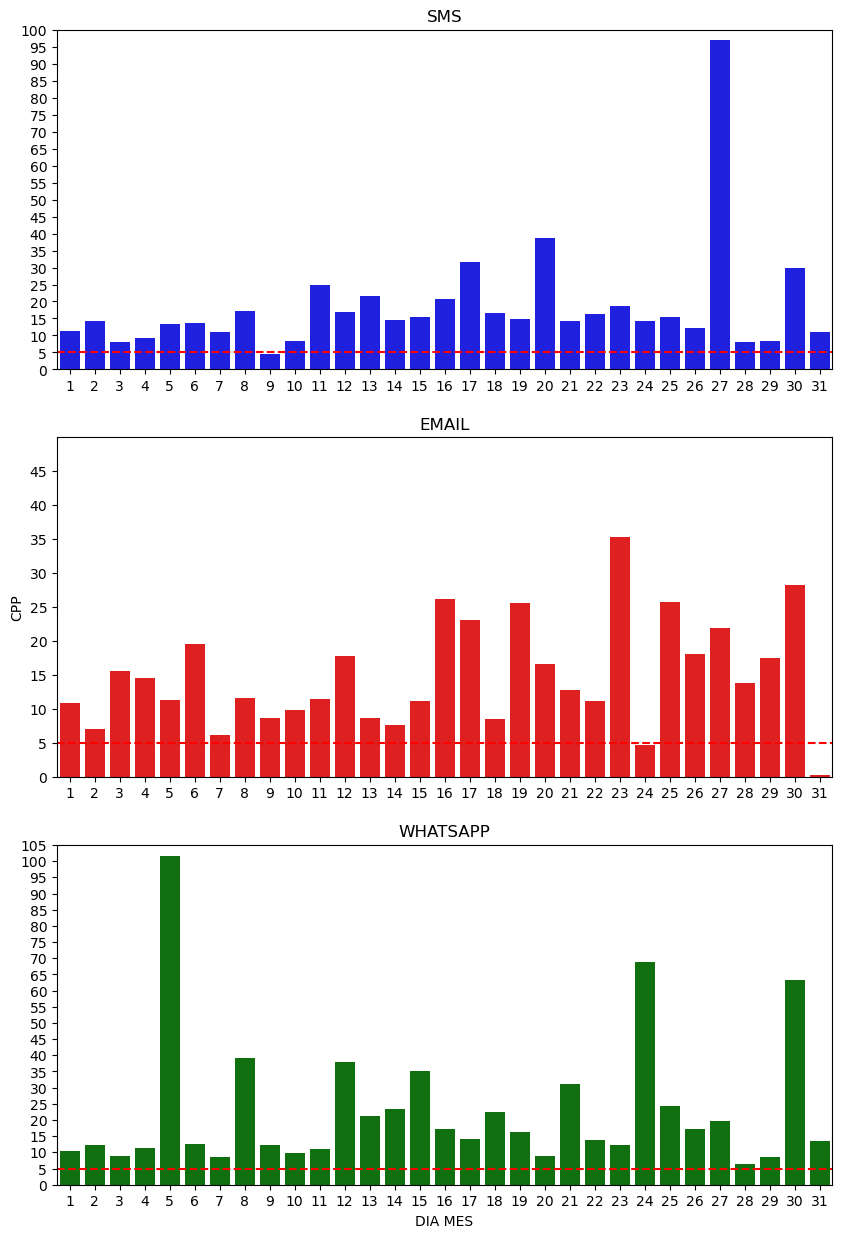

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium'] == 'SMS']['CPP'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 100)
axs[0].yaxis.set_ticks(range(0, 101, 5))
axs[0].axhline(y=5, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='E-MAIL']['CPP'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 50)
axs[1].yaxis.set_ticks(range(0, 50, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_Canal_grouped['Dia_mes'], y=KPI_Canal_grouped[KPI_Canal_grouped['medium']=='WHATSAPP']['CPP'], ax=axs[2],color='green')
axs[2].set_title('WHATSAPP')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 105)
axs[2].yaxis.set_ticks(range(0, 106, 5))
axs[2].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Faixa de Atraso Sob Ótica do CPP:

121 - 180 - 3, 7, 9, 17, 28, 29

181 - 360 - 9, 23, 31


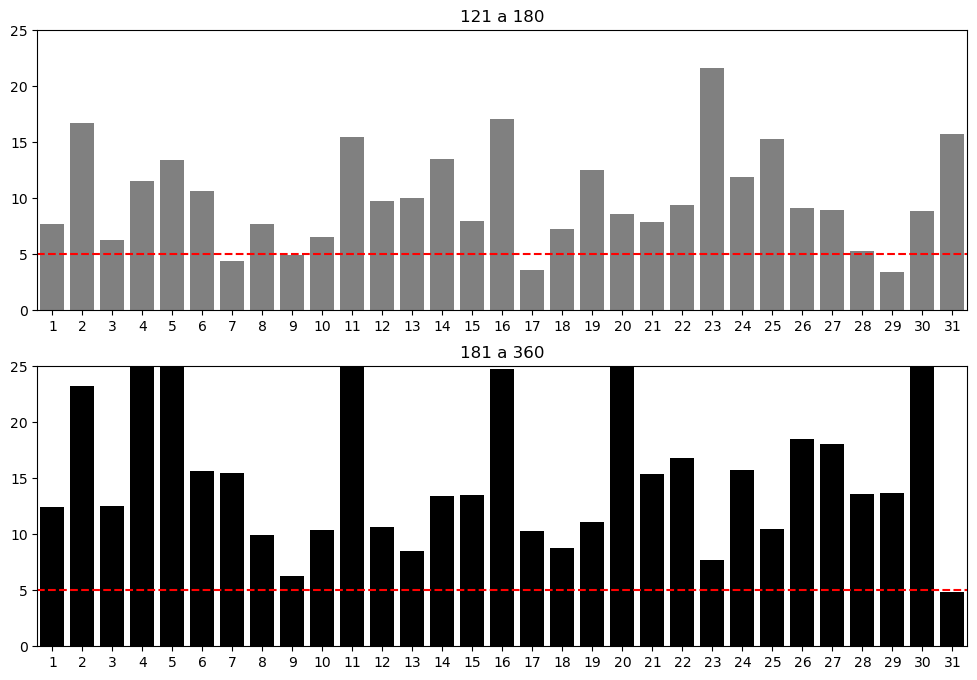

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
#121 a 180
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==5]['CPP'], ax=axs[0],color='gray')
axs[0].set_title('121 a 180')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 25)
axs[0].yaxis.set_ticks(range(0, 26, 5)) 
axs[0].axhline(y=5, color='r', linestyle='--')
#181 a 360	
sns.barplot(x=KPI_FA_grouped['Dia_mes'], y=KPI_FA_grouped[KPI_FA_grouped['cod_cluster']==6]['CPP'], ax=axs[1],color='black')
axs[1].set_title('181 a 360')
axs[1].set_xlabel('') 
axs[1].set_ylabel('')
axs[1].set_ylim(0, 25)
axs[1].yaxis.set_ticks(range(0, 26, 5)) 
axs[1].axhline(y=5, color='r', linestyle='--');

Melhores Períodos para Estímulo por Canal e Faixa de Atraso Sob Ótica do CPP:

SMS (181 - 360) 9, 10

E-MAIL (181 - 360) - 31

SMS (121 - 180) - 9, 10, 28, 29

E-MAIL (121 - 180) - 7

WHATSAPP (121 - 180) - 7, 29

***

Pensando em renovação de balde, foi possível averiguar que esses são os melhores dias para explorar os não localizados > 

Melhores Períodos para Estímulo por Canal Sob Ótica do CPL:

URA - 10, 16 

SMS - 7, 11 até 16

EMAIL - Durante todo mês

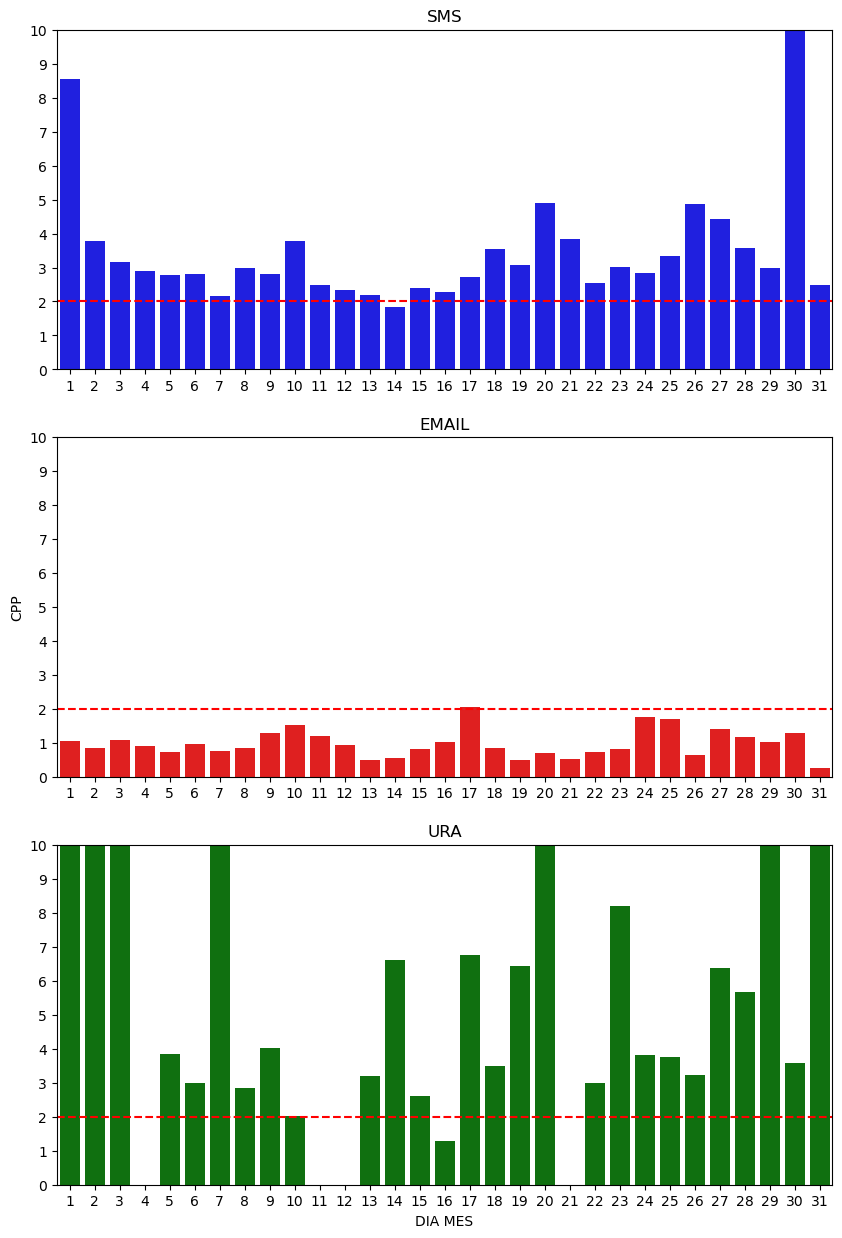

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
#SMS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type'] == 'SMS']['cpl'], ax=axs[0], color='blue')
axs[0].set_title('SMS')
axs[0].set_xlabel('') 
axs[0].set_ylabel('')
axs[0].set_ylim(0, 10)
axs[0].yaxis.set_ticks(range(0, 11, 1))
axs[0].axhline(y=2, color='r', linestyle='--') 
#EMAIL
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='EMAIL']['cpl'], ax=axs[1],color='red')
axs[1].set_title('EMAIL')
axs[1].set_xlabel('') 
axs[1].set_ylabel('CPP')
axs[1].set_ylim(0, 10)
axs[1].yaxis.set_ticks(range(0, 11, 1)) 
axs[1].axhline(y=2, color='r', linestyle='--')
#WHATS
sns.barplot(x=KPI_CPL_grouped['Dia_mes'], y=KPI_CPL_grouped[KPI_CPL_grouped['approach_type']=='CALL_CELLPHONE']['cpl'], ax=axs[2],color='green')
axs[2].set_title('URA')
axs[2].set_xlabel('DIA MES') 
axs[2].set_ylabel('')
axs[2].set_ylim(0, 10)
axs[2].yaxis.set_ticks(range(0, 11, 1))
axs[2].axhline(y=2, color='r', linestyle='--');

Uma sugestão futura é um possível enriquecimento na base de E-mail, visto que é uma base boa para trabalhar pensando em renovação de balde, porém é uma base pequena (cerca de 5% do público total é não localizado e possui Email). 

In [ ]:
round(pd.crosstab(consolidacao['contact_status'], consolidacao['contact_type'],  normalize=True) * 100,2)

contact_type,CELLPHONE,DEVICE_TOKEN,EMAIL
contact_status,,,
CONFIRMED,32.67,5.83,13.01
CREATED,43.93,0.00,4.51
UNAVAILABLE,0.05,0.00,0.00


## CORRELAÇÃO

In [ ]:
corr_cpp = '''  
select
	created_at,
	case when medium != 'PUSH' then medium end canal,
	sum(Total) PRODUCAO_TOTAL,
	sum(custo / total)::float CPP_TOTAL
from
	(
	select
		ap39.created_at,
		ap39.medium,
		COUNT(*) as total,
		c.custo
	from
		quiteja_dados.analitico_producao_39 ap39
	join (
		select
			ae.sent_at,
			case
				when f.approach_type = 'EMAIL' then 'E-MAIL'
				when f.approach_type = 'ORGANIC' then 'ORGANICO'
				else f.approach_type
			end as approach_type,
			SUM(f.approach_cost) as custo
		from
			quiteja_dados.analitico_estimulos_39 ae
		join quiteja_lake.firing f on
			ae.firing_id = f.id
			and ae.approach_type = f.approach_type
		group by
			1,
			2
    ) c on
		c.sent_at = ap39.created_at
		and c.approach_type = ap39.medium
	group by
		1,
		2,
		c.custo
) as subquery
group by
	1,2
order by
	1,2

'''

In [ ]:
cpp_corr = sql_df(corr_cpp)
cpp_corr['created_at'] = pd.to_datetime(cpp_corr['created_at'])

In [ ]:
cpp_corr.corr()

C:\Users\mateus.schualtz\AppData\Local\Temp\ipykernel_30060\336126212.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cpp_corr.corr()


,producao_total,cpp_total
producao_total,1.000000,0.021087
cpp_total,0.021087,1.000000


In [ ]:
cpp_corr['Dia'] = cpp_corr['created_at'].dt.day_name()

<Axes: title={'center': 'cpp_total'}, xlabel='canal'>

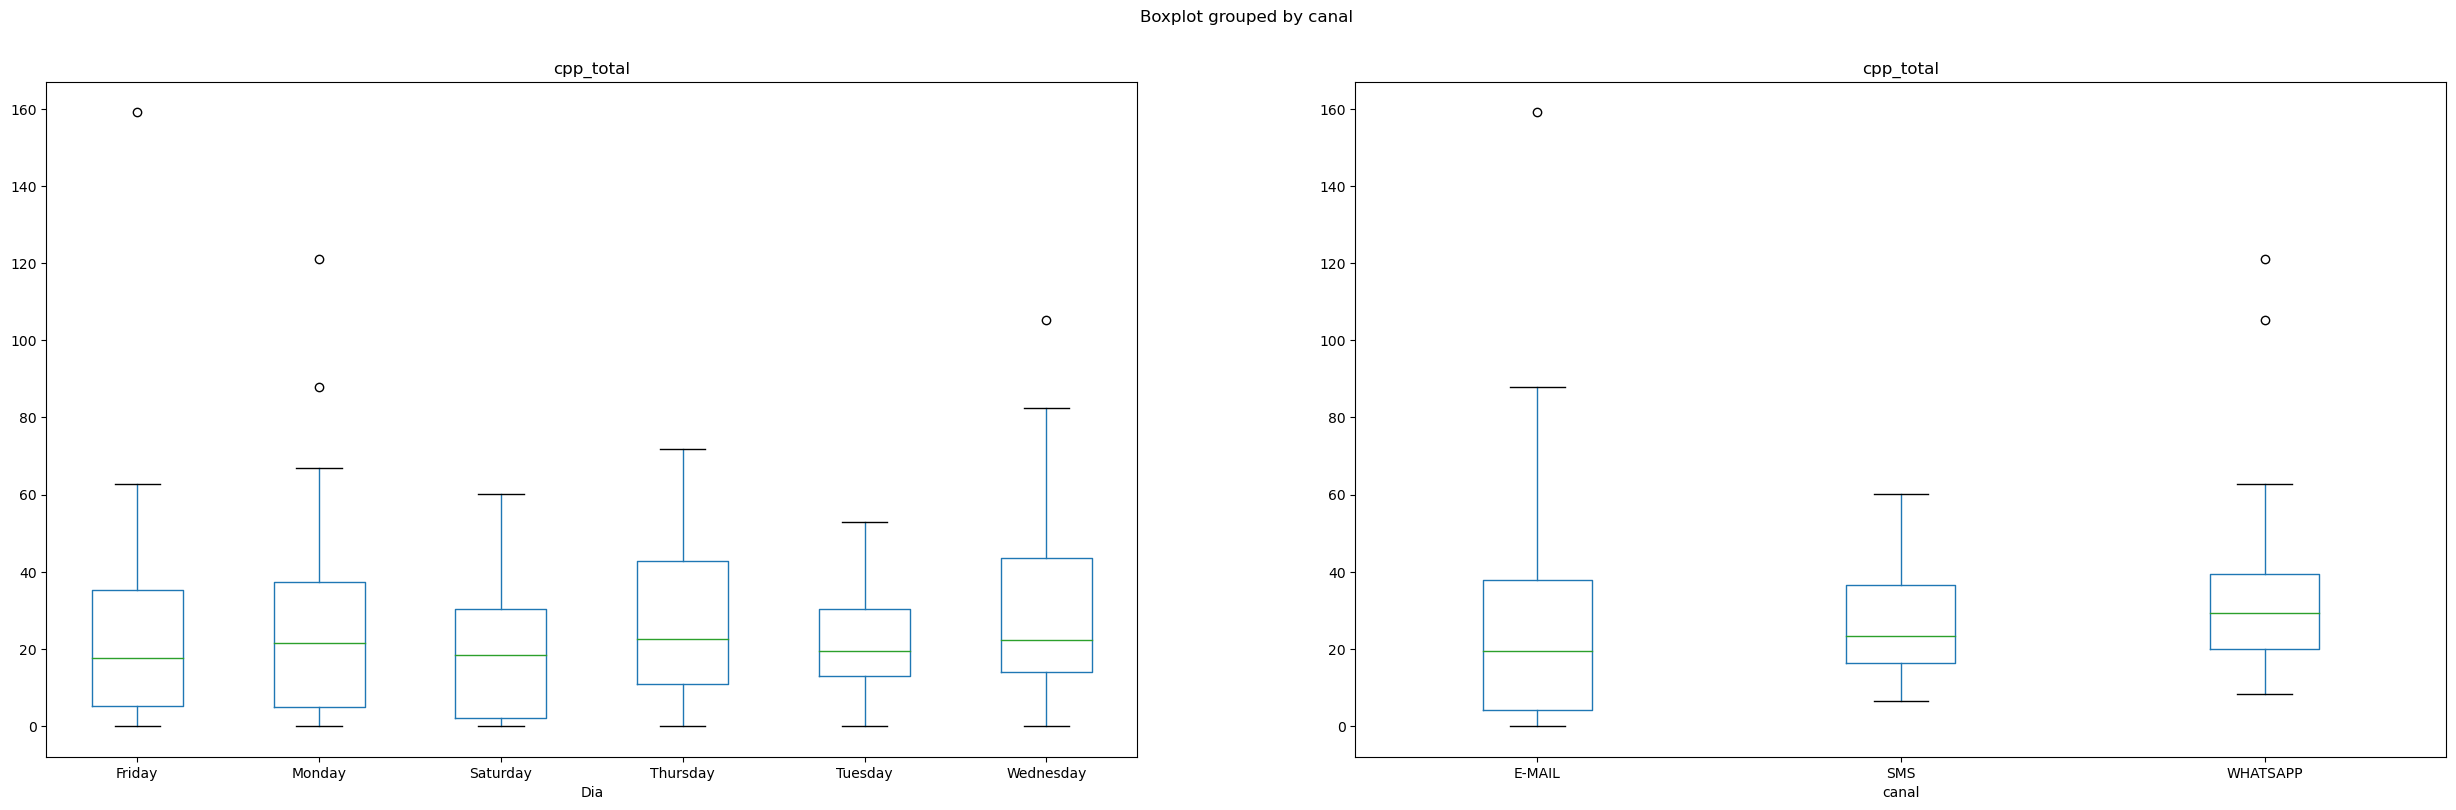

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
cpp_corr.boxplot(by='Dia', column='cpp_total', grid=False, ax=ax1)
cpp_corr.boxplot(by='canal', column='cpp_total', grid=False, ax=ax2)

In [ ]:
modelo_cpp = ols('cpp_total ~ Dia * canal', data = cpp_corr).fit()
resultado_cpp = sm.stats.anova_lm(modelo_cpp)
resultado_cpp

,df,sum_sq,mean_sq,F,PR(>F)
Dia,5.0,2678.674096,535.734819,0.706407,0.620525
canal,2.0,624.907396,312.453698,0.411994,0.663901
Dia:canal,10.0,3961.754526,396.175453,0.522387,0.868865
Residual,71.0,53845.964373,758.393864,NaN,NaN


<Axes: title={'center': 'producao_total'}, xlabel='canal'>

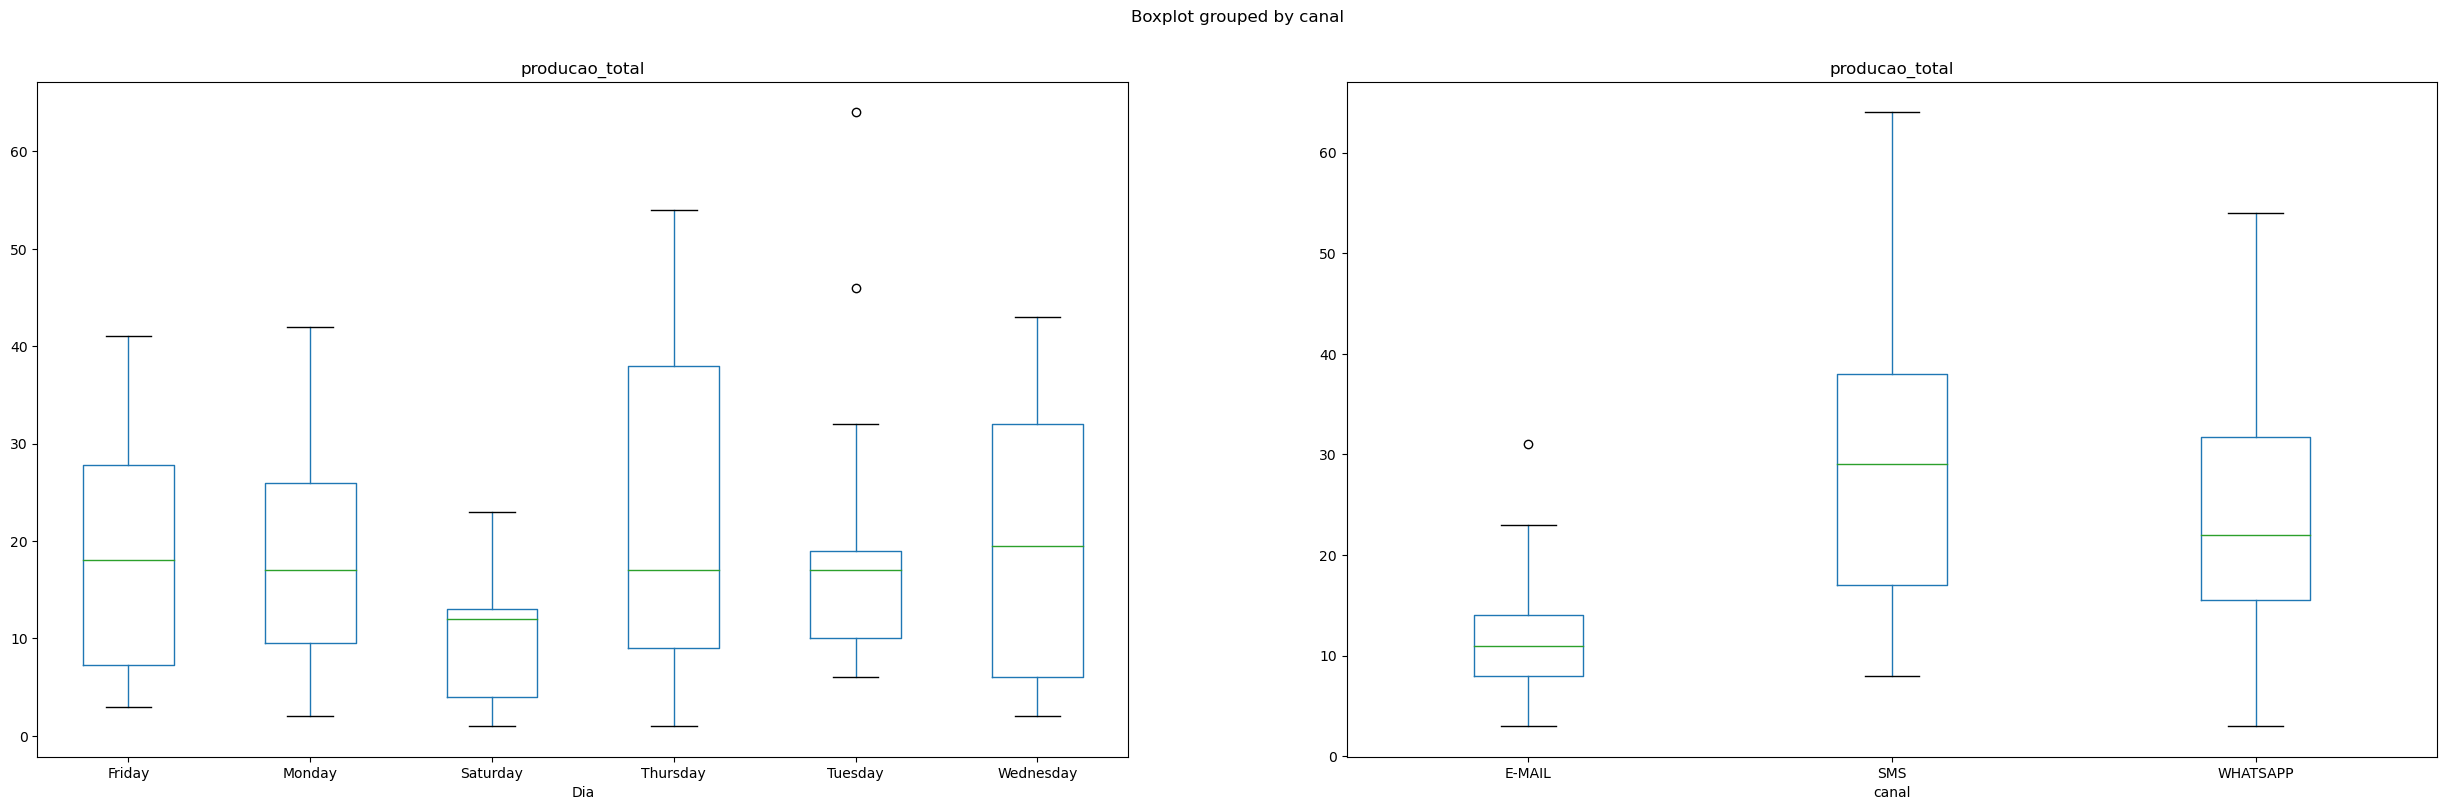

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
cpp_corr.boxplot(by='Dia', column='producao_total', grid=False, ax=ax1)
cpp_corr.boxplot(by='canal', column='producao_total', grid=False, ax=ax2)

In [ ]:
modelo_cpp = ols('producao_total ~ Dia * canal', data = cpp_corr).fit()
resultado_cpp = sm.stats.anova_lm(modelo_cpp)
resultado_cpp

,df,sum_sq,mean_sq,F,PR(>F)
Dia,5.0,1202.886797,240.577359,2.357614,4.883427e-02
canal,2.0,4038.673959,2019.336979,19.789133,1.477047e-07
Dia:canal,10.0,1789.702484,178.970248,1.753876,8.545713e-02
Residual,71.0,7245.033333,102.042723,NaN,NaN


In [ ]:
cpp_corr['canal_dia'] = cpp_corr['canal'].astype(str) + '_' + cpp_corr['Dia'].astype(str)

In [ ]:
tukey = pairwise_tukeyhsd(endog=cpp_corr['producao_total'], groups=cpp_corr['canal_dia'], alpha=0.05)

In [ ]:
tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
tukey_summary[tukey_summary['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
14,E-MAIL_Friday,SMS_Thursday,23.0000,0.0340,0.7766,45.2234,True
15,E-MAIL_Friday,SMS_Tuesday,25.5333,0.0045,4.2560,46.8106,True
16,E-MAIL_Friday,SMS_Wednesday,23.6000,0.0250,1.3766,45.8234,True
19,E-MAIL_Friday,WHATSAPP_Thursday,23.0000,0.0340,0.7766,45.2234,True
36,E-MAIL_Monday,SMS_Tuesday,22.9333,0.0207,1.6560,44.2106,True
110,E-MAIL_Wednesday,SMS_Tuesday,22.9333,0.0207,1.6560,44.2106,True
126,None_Friday,SMS_Tuesday,27.6667,0.0135,2.8201,52.5132,True
127,None_Friday,SMS_Wednesday,25.7333,0.0485,0.0719,51.3947,True
137,None_Monday,SMS_Friday,25.8667,0.0458,0.2053,51.5281,True
138,None_Monday,SMS_Monday,25.1667,0.0435,0.3201,50.0132,True


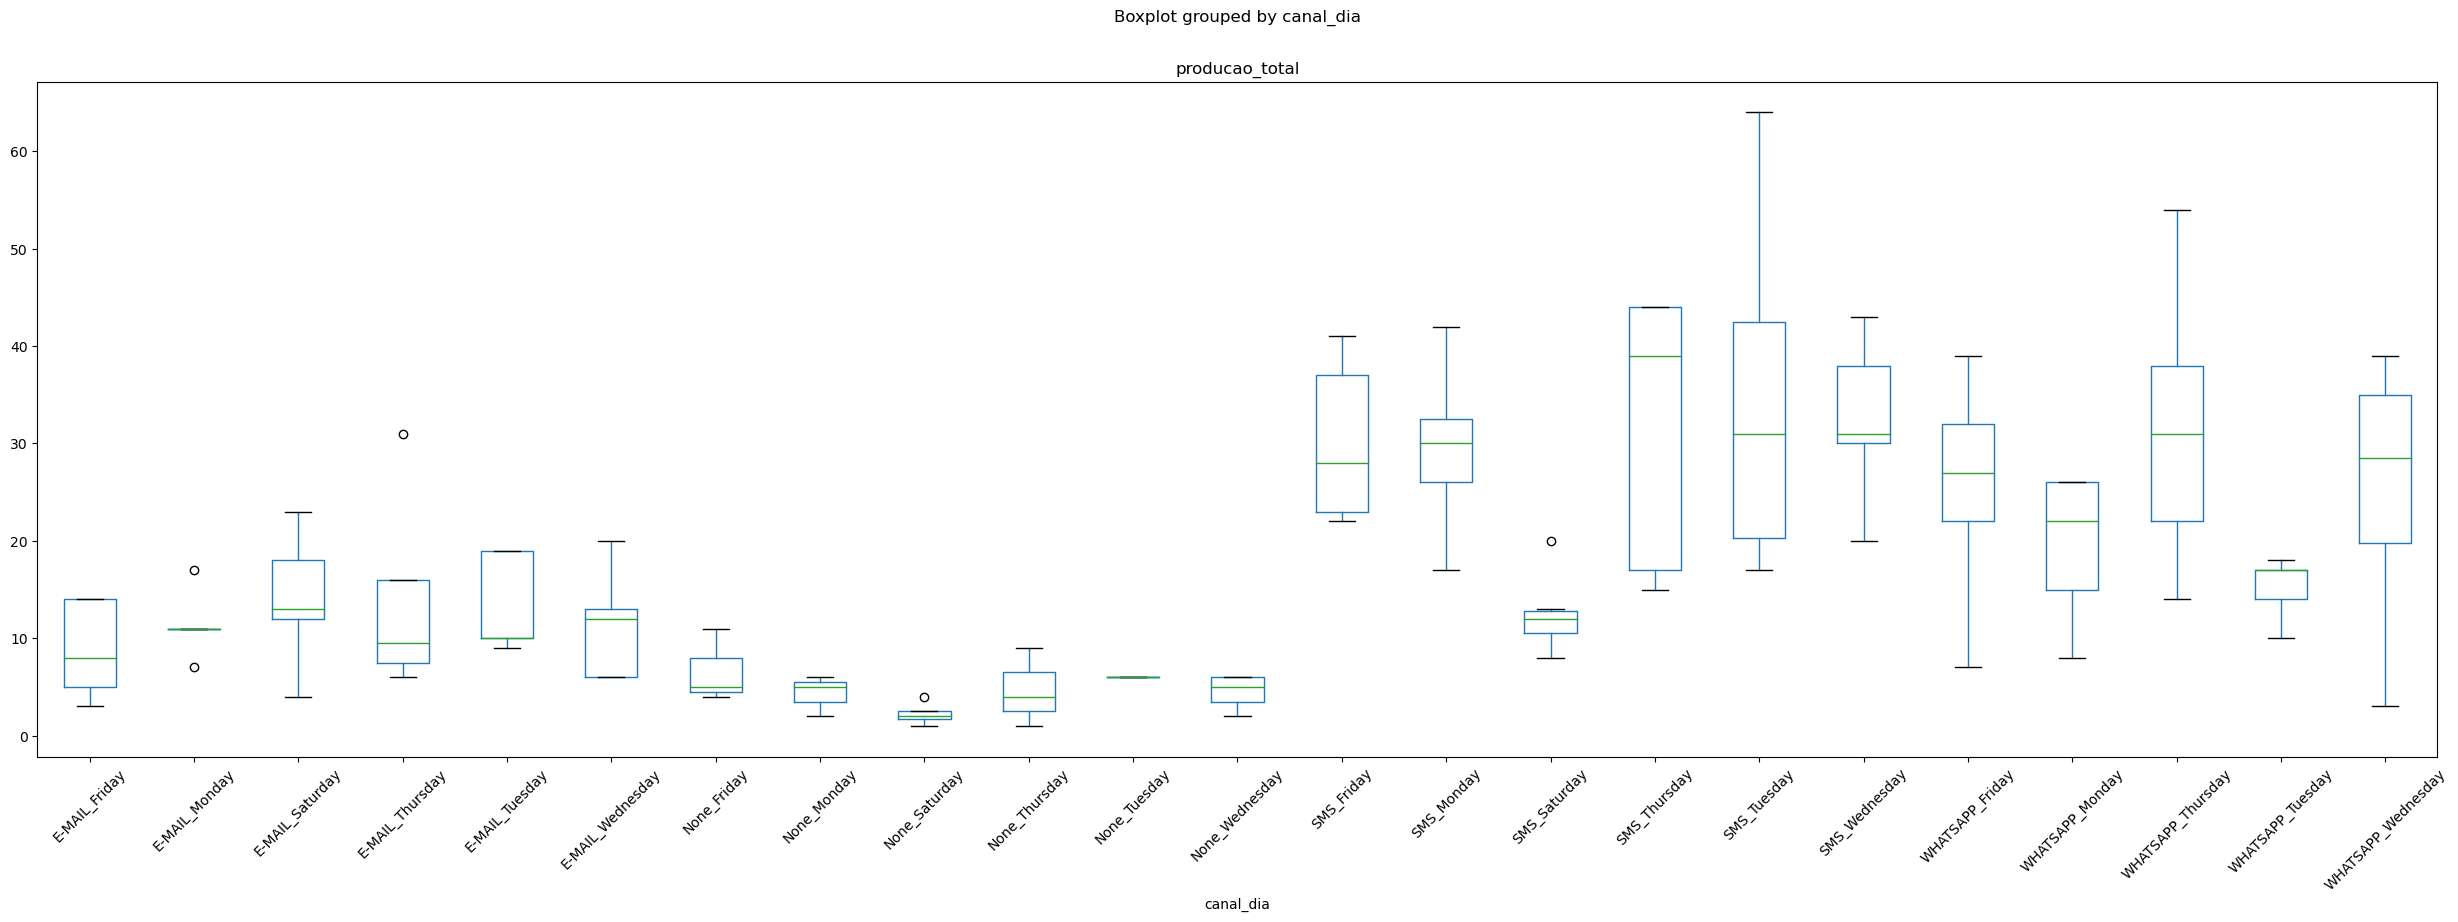

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_corr.boxplot(by='canal_dia', column='producao_total', grid=False, ax=ax1)
plt.xticks(rotation=45);

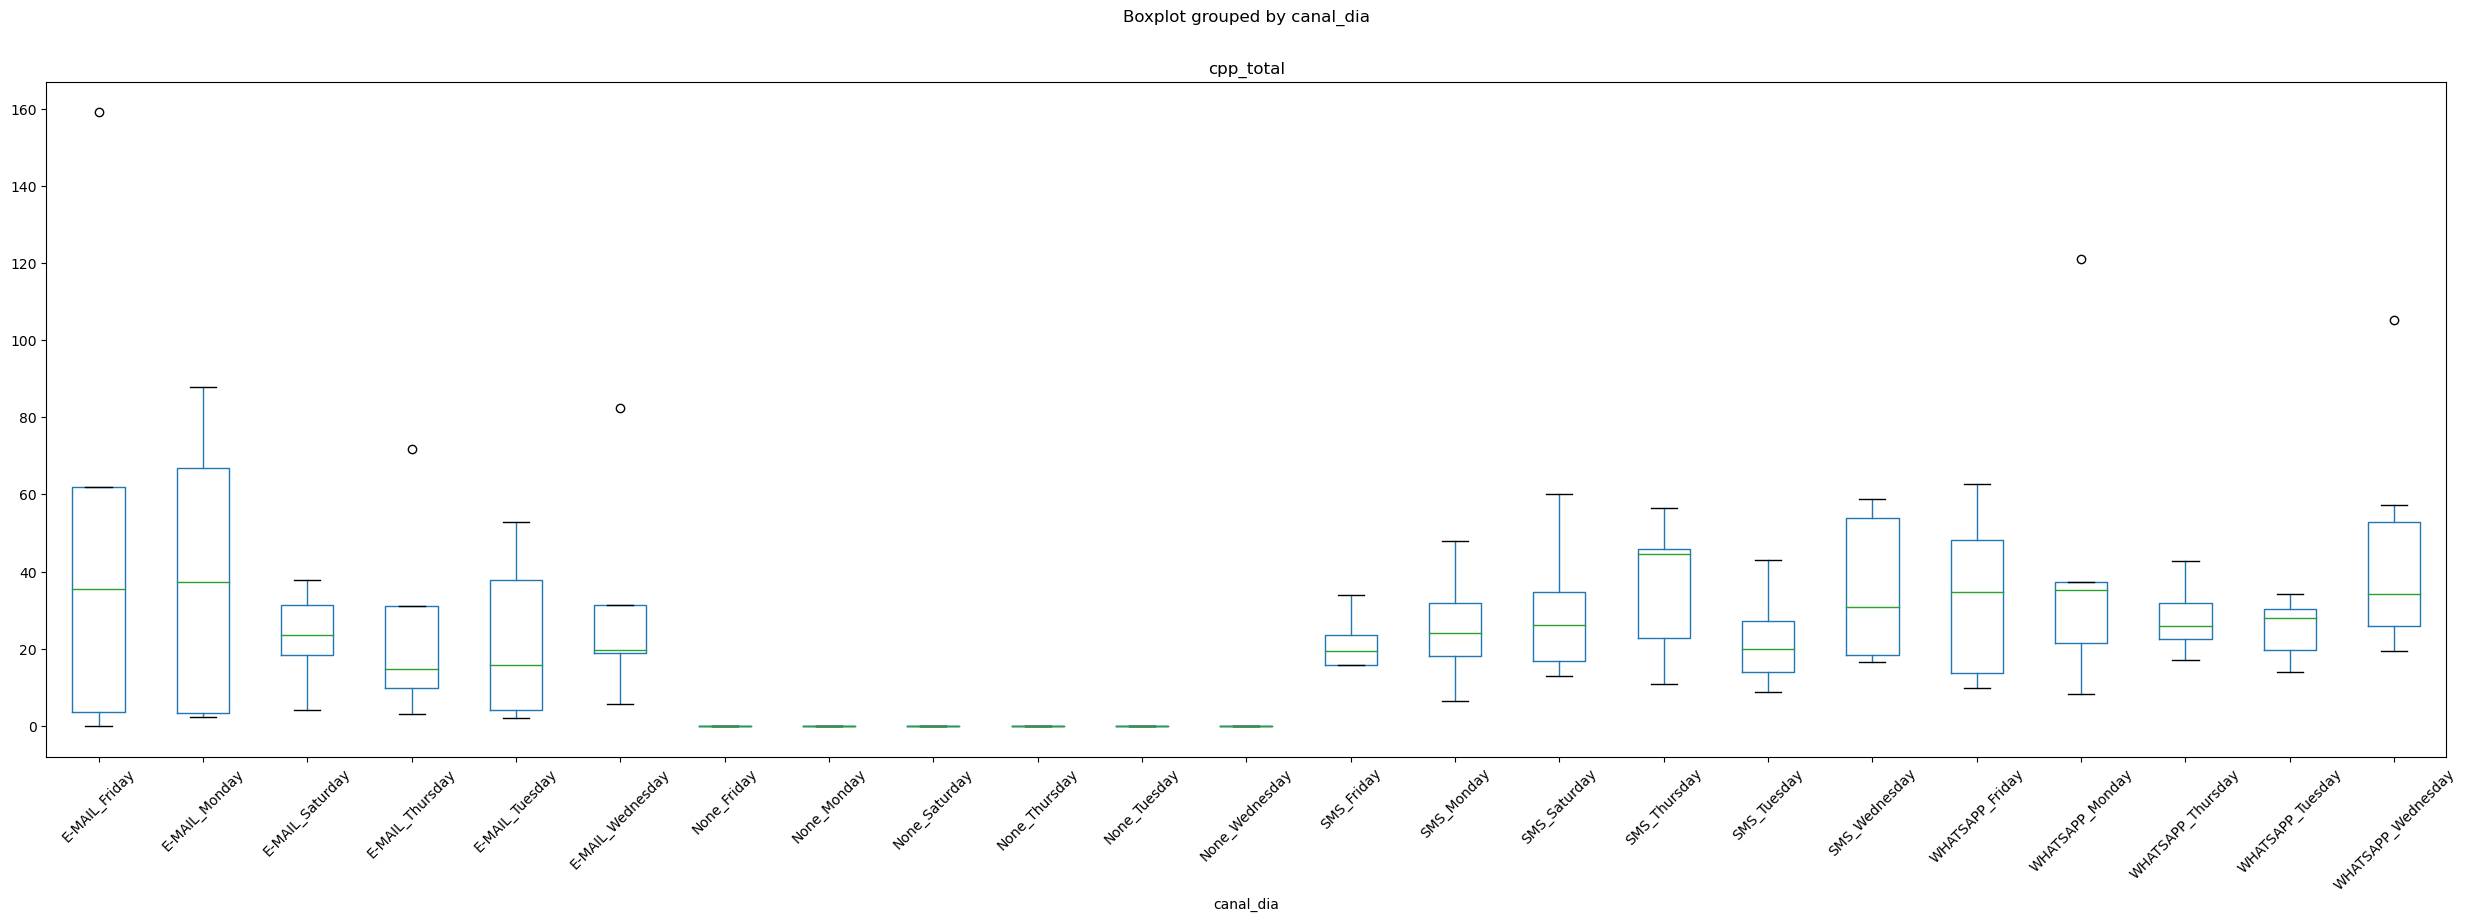

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_corr.boxplot(by='canal_dia', column='cpp_total', grid=False, ax=ax1)
plt.xticks(rotation=45);

In [ ]:
cpp_group = cpp_corr.groupby(by='canal_dia').agg('sum','producao_total').reset_index()

In [ ]:
cpp_group

,canal_dia,producao_total,cpp_total
0,E-MAIL_Friday,44,260.164589
1,E-MAIL_Monday,57,197.601770
2,E-MAIL_Saturday,70,115.218485
3,E-MAIL_Thursday,56,104.173857
4,E-MAIL_Tuesday,67,112.861704
5,E-MAIL_Wednesday,57,158.005477
6,None_Friday,20,0.000000
7,None_Monday,13,0.000000
8,None_Saturday,9,0.000000
9,None_Thursday,14,0.000000


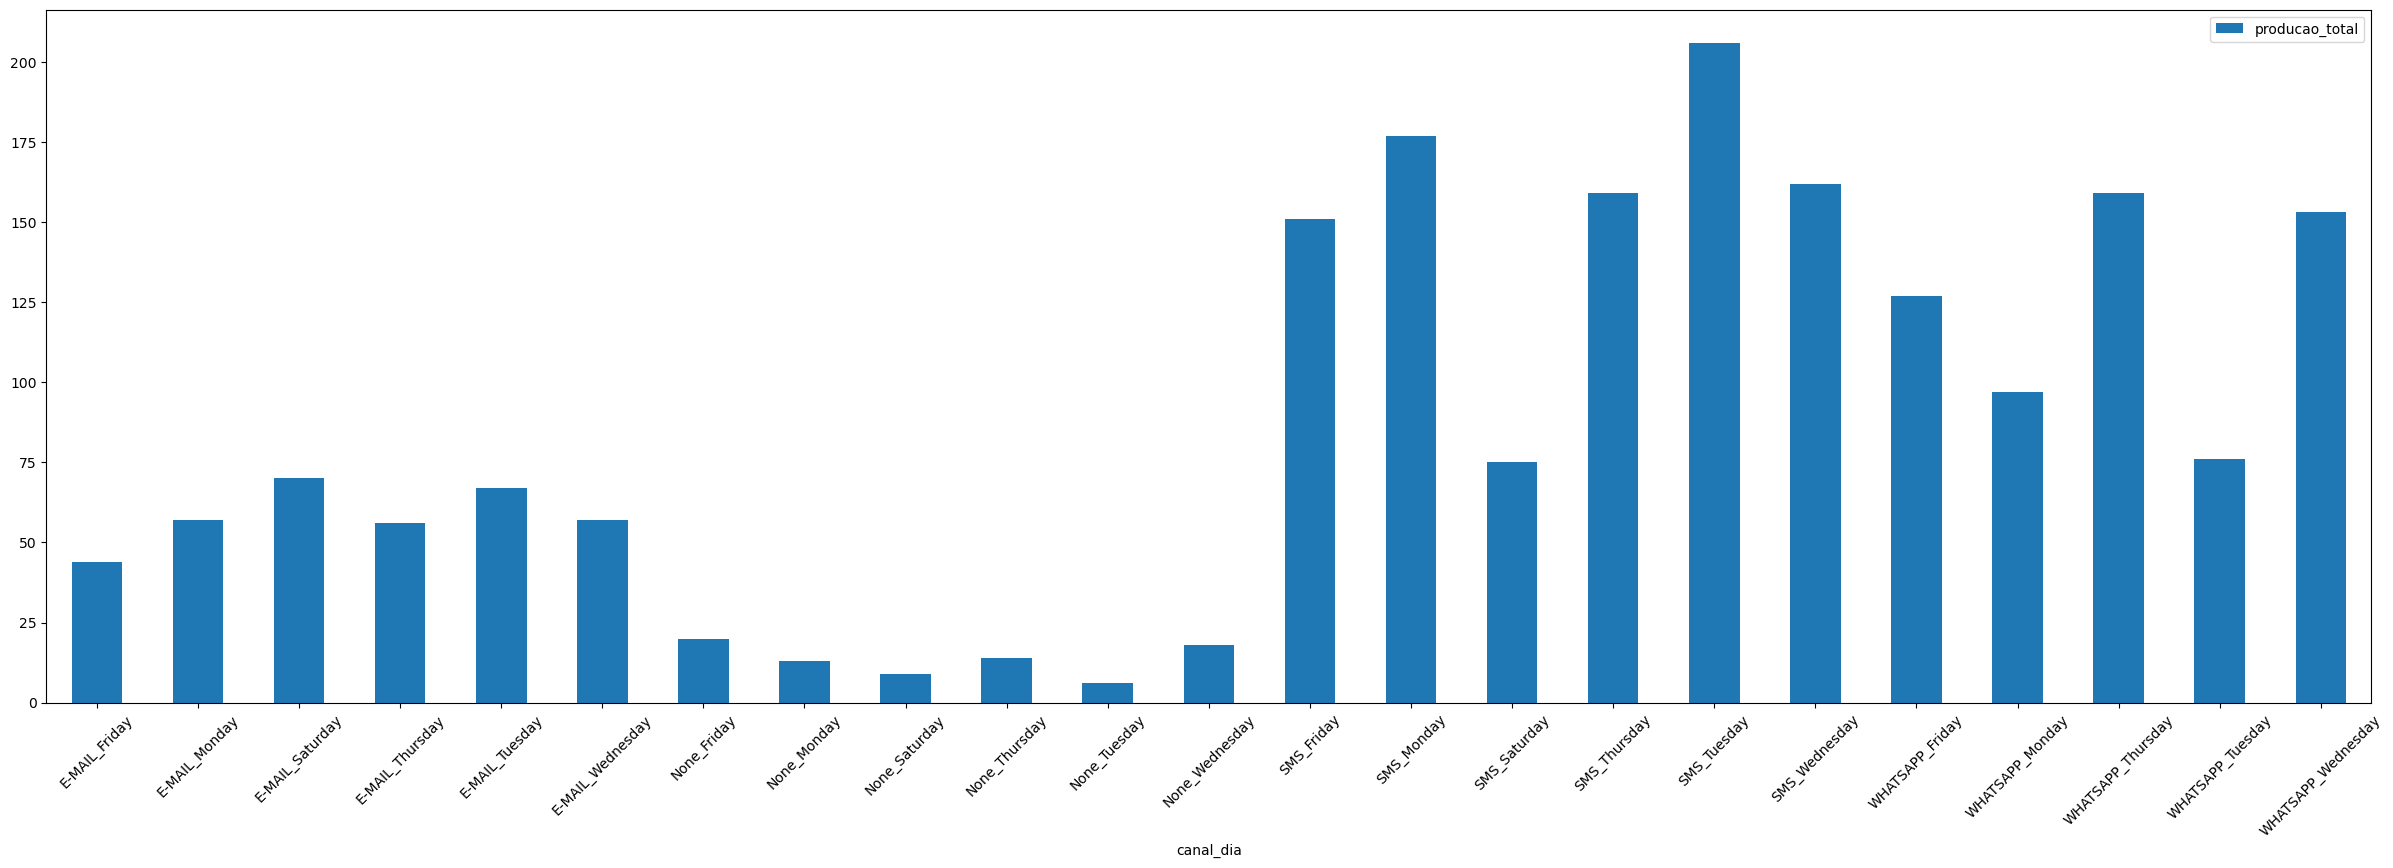

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(30, 9))
cpp_group.plot(kind='bar', x = 'canal_dia', y='producao_total', ax=ax1)
plt.xticks(rotation=45);

In [24]:
cash_custo = ''' 
with cash as(
select
    p.creditor_id,
    payed_date::date,
    case when pm.medium = 'push' then 'PUSH'
    	 when pm.medium = 'whatsapp' then 'WHATSAPP'
    	 when pm.medium = 'sms' then 'SMS'
    	 when pm.medium = 'email' then 'EMAIL'
    	 else 'ORGANIC'
    	 end canal,
    sum(p.value * pot.fee) comissionado
from
                quiteja_lake.payment p
left join (
    select
        deal_id,
        max(days_of_delay) days_of_delay
    from
        quiteja_lake.operation o
    where
        o.active is true
    group by
        1) o on
                o.deal_id = p.deal_id
left join quiteja_lake.potential pot on    o.days_of_delay between coalesce(pot.min_days_of_delay,    0) and coalesce(pot.max_days_of_delay,    999999)
    and pot.active is true
    and pot.creditor_id = p.creditor_id
left join quiteja_lake.proposal pp on pp.deal_id = o.deal_id and pp.status = 'AGREED'
join quiteja_lake.proposal_marketing pm on pp.id = pm.proposal_id
where
                1 = 1
    and date(p.payed_date) between '2024-01-01'::date and current_date::date 
     and p.status = 'PAYED'
    and p.type = 'DOWN_PAYMENT'
    and p.creditor_id = '39'
group by
    1,2,3),
    
custo as (
select 
	created_at::date,
	approach_type,
    creditor_id,
    sum(notifications * approach_cost) custo_geral
from
    quiteja_lake.firing
where 
    created_at::date  between '2024-01-01'::date and current_date::date 
    and creditor_id = 39
group by 1,2,3)


select 
created_at,
approach_type,
comissionado::float,
custo_geral::float,
case when custo_geral = 0 then 0 else comissionado  / custo_geral::float end cash_custo
from cash
join custo on cash.canal = custo.approach_type and custo.created_at = cash.payed_date
where approach_type not in ('ORGANIC', 'PUSH')
order by 1, 2 desc


'''

In [25]:
cash_custo = sql_df(cash_custo)

In [26]:
cash_custo['created_at'] = pd.to_datetime(cash_custo['created_at'])
cash_custo['Dia'] = cash_custo['created_at'].dt.day_name()

In [31]:
modelo_cc = ols('cash_custo ~ Dia * approach_type', data = cash_custo).fit()
resultado_cc = sm.stats.anova_lm(modelo_cc)
resultado_cc

,df,sum_sq,mean_sq,F,PR(>F)
Dia,4.0,26700.969935,6675.242484,0.818882,0.519524
approach_type,2.0,16836.835480,8418.417740,1.032726,0.363810
Dia:approach_type,8.0,46120.718508,5765.089814,0.707230,0.683675
Residual,48.0,391279.163719,8151.649244,NaN,NaN


In [29]:
@interact(x=['approach_type','Dia'], y=['comissionado','custo_geral','cash_custo'])
def boxplot(x,y):
    fig, (ax1) = plt.subplots(1, figsize=(30, 9))
    sns.boxplot(x=x, y=y, data=cash_custo[cash_custo['cash_custo'] < 5], ax=ax1)
    plt.xticks(rotation=45);

interactive(children=(Dropdown(description='x', options=('approach_type', 'Dia'), value='approach_type'), Drop…

In [20]:
cash_custo

,created_at,approach_type,comissionado,custo_geral,cash_custo,Dia
0,2024-05-03,SMS,34.3736,543.4600,0.063250,Friday
1,2024-05-06,SMS,203.7672,500.7240,0.406945,Monday
2,2024-05-07,WHATSAPP,220.4361,0.0000,220.436100,Tuesday
3,2024-05-07,SMS,201.0207,838.0160,0.239877,Tuesday
4,2024-05-08,WHATSAPP,193.2581,1399.9518,0.138046,Wednesday
...,...,...,...,...,...,...
58,2024-06-12,SMS,251.0001,500.5100,0.501489,Wednesday
59,2024-06-12,EMAIL,56.5451,117.3510,0.481846,Wednesday
60,2024-06-13,WHATSAPP,40.5921,498.4317,0.081440,Thursday
61,2024-06-13,SMS,600.6947,388.4860,1.546245,Thursday
